Through this analysis of the dataset, I want to answer the following questions in order to provide insights for the travellers first time to seattle on airbnb pricing and location to choose.
1. What are the busiest times of the year to visit Seattle? By how much do prices spike?
2. What is the the vibe of each Seattle neighborhood?
3. What are the top factors that affect aparment pricing in Seattle?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/reviews.csv


In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import floor
import re
import copy
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [3]:
listings=pd.read_csv("/kaggle/input/seattle/listings.csv")
reviews=pd.read_csv("/kaggle/input/seattle/reviews.csv")
calendar=pd.read_csv("/kaggle/input/seattle/calendar.csv")

# **A Look at the Data and Prepocessing Data**

# **1.  Listings**

In [8]:
listings.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_id,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,956883,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,9851441,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,1452570,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [ ]:
listings.shape

In [28]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 81 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   object 
 1   name                              3818 non-null   object 
 2   summary                           3641 non-null   object 
 3   space                             3249 non-null   object 
 4   description                       3818 non-null   object 
 5   experiences_offered               3818 non-null   object 
 6   neighborhood_overview             2786 non-null   object 
 7   notes                             2212 non-null   object 
 8   transit                           2884 non-null   object 
 9   host_id                           3818 non-null   int64  
 10  host_name                         3816 non-null   object 
 11  host_since                        3816 non-null   object 
 12  host_a

In [ ]:
listings.isnull().sum()

In [ ]:
listings.review_scores_value.mean()

In [ ]:
#show columns with missing values
listings.columns[listings.isnull().any()]

* prepocessing data

In [4]:
#drop some unrelated columns
listings.drop(columns=['listing_url','scrape_id','last_scraped','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url','host_location','host_url', 'host_thumbnail_url', 'host_picture_url'],inplace=True)

In [24]:
listings['id']=listings['id'].astype(str)

 # 2. Calender

In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [64]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   id         1393570 non-null  object        
 1   date       1393570 non-null  datetime64[ns]
 2   available  1393570 non-null  object        
 3   price      934542 non-null   object        
 4   month      1393570 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 53.2+ MB


Looks like when the apartment is not available, the price would be nan.

In [18]:
calendar=calendar.rename(columns ={"listing_id":"id"})
calendar['date']=pd.to_datetime(calendar.date)# Change datatype of datetime
calendar['month'] =calendar['date'].dt.month
calendar['id']=calendar['id'].astype(str)# Convert listingid to string
calendar.head()

,id,date,available,price,month
0,241032,2016-01-04,t,$85.00,1
1,241032,2016-01-05,t,$85.00,1
2,241032,2016-01-06,f,NaN,1
3,241032,2016-01-07,f,NaN,1
4,241032,2016-01-08,f,NaN,1


# 3.reviews

In [ ]:
reviews.head()

In [63]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [ ]:
reviews.fillna('none',inplace=True)

# In-Depth Analysis

 1. What are the busiest times of the year to visit Seattle? By how much do prices spike?

In [29]:
temp_listings=listings[['id','neighbourhood_cleansed']]
temp_listings.head()

,id,neighbourhood_cleansed
0,241032,West Queen Anne
1,953595,West Queen Anne
2,3308979,West Queen Anne
3,7421966,West Queen Anne
4,278830,West Queen Anne


In [68]:
# Join column neighbourhood_cleansed from listings to calendar,cn represents calendar merge neibourhood
cn=pd.merge(calendar, temp_listings,how='left',on='id')
cn.head()

,id,date,available,price,month,neighbourhood_cleansed
0,241032,2016-01-04,t,$85.00,1,West Queen Anne
1,241032,2016-01-05,t,$85.00,1,West Queen Anne
2,241032,2016-01-06,f,NaN,1,West Queen Anne
3,241032,2016-01-07,f,NaN,1,West Queen Anne
4,241032,2016-01-08,f,NaN,1,West Queen Anne


In [81]:
# Average Daily booked rate group by month
dailybookingrate= pd.DataFrame(cn[cn['available'] =='f'].groupby('month')['available'].count() / 30  / 3818 *100)
dailybookingrate

,available
month,
1,43.306269
2,32.653222
3,30.050637
4,33.615331
5,33.514056
6,32.561551
7,38.533263
8,36.678016
9,32.559804


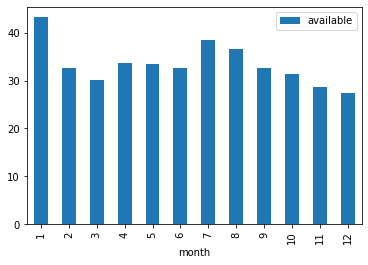

In [72]:
dailybookingrate.plot(kind='bar')

January,July and August has the highest average daily booking rate, so they are the busiest time to visit Seattle.